In [1]:
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
import os
from undistort import undistort
from threshold_select import bgr_to_grayscale, bgr_to_hls, hls_channel_select, mag_sobel_hls, dir_sobel_hls, sobel_hls
from perspective_transform import perspective_transform
from mask import calculate_vertices, region_of_interest

print('Done Importing')

Done Importing


In [2]:
images_path = glob.glob('./test_images/test*.jpg')
images_filename = [os.path.basename(path) for path in images_path]
images = [cv2.imread(path) for path in images_path]
# images_dict = dict(zip(images_filename, images))
print('Images: ', images_filename)

camera_calibration_file = './camera_calibration.p'
with open(camera_calibration_file, mode='rb') as f:
    cali_data = pickle.load(f)
mtx, dist = cali_data['mtx'], cali_data['dist']
print('Camera matrix:', mtx)
print('Distortion coefficients: ', dist)

Images:  ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
Camera matrix: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion coefficients:  [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


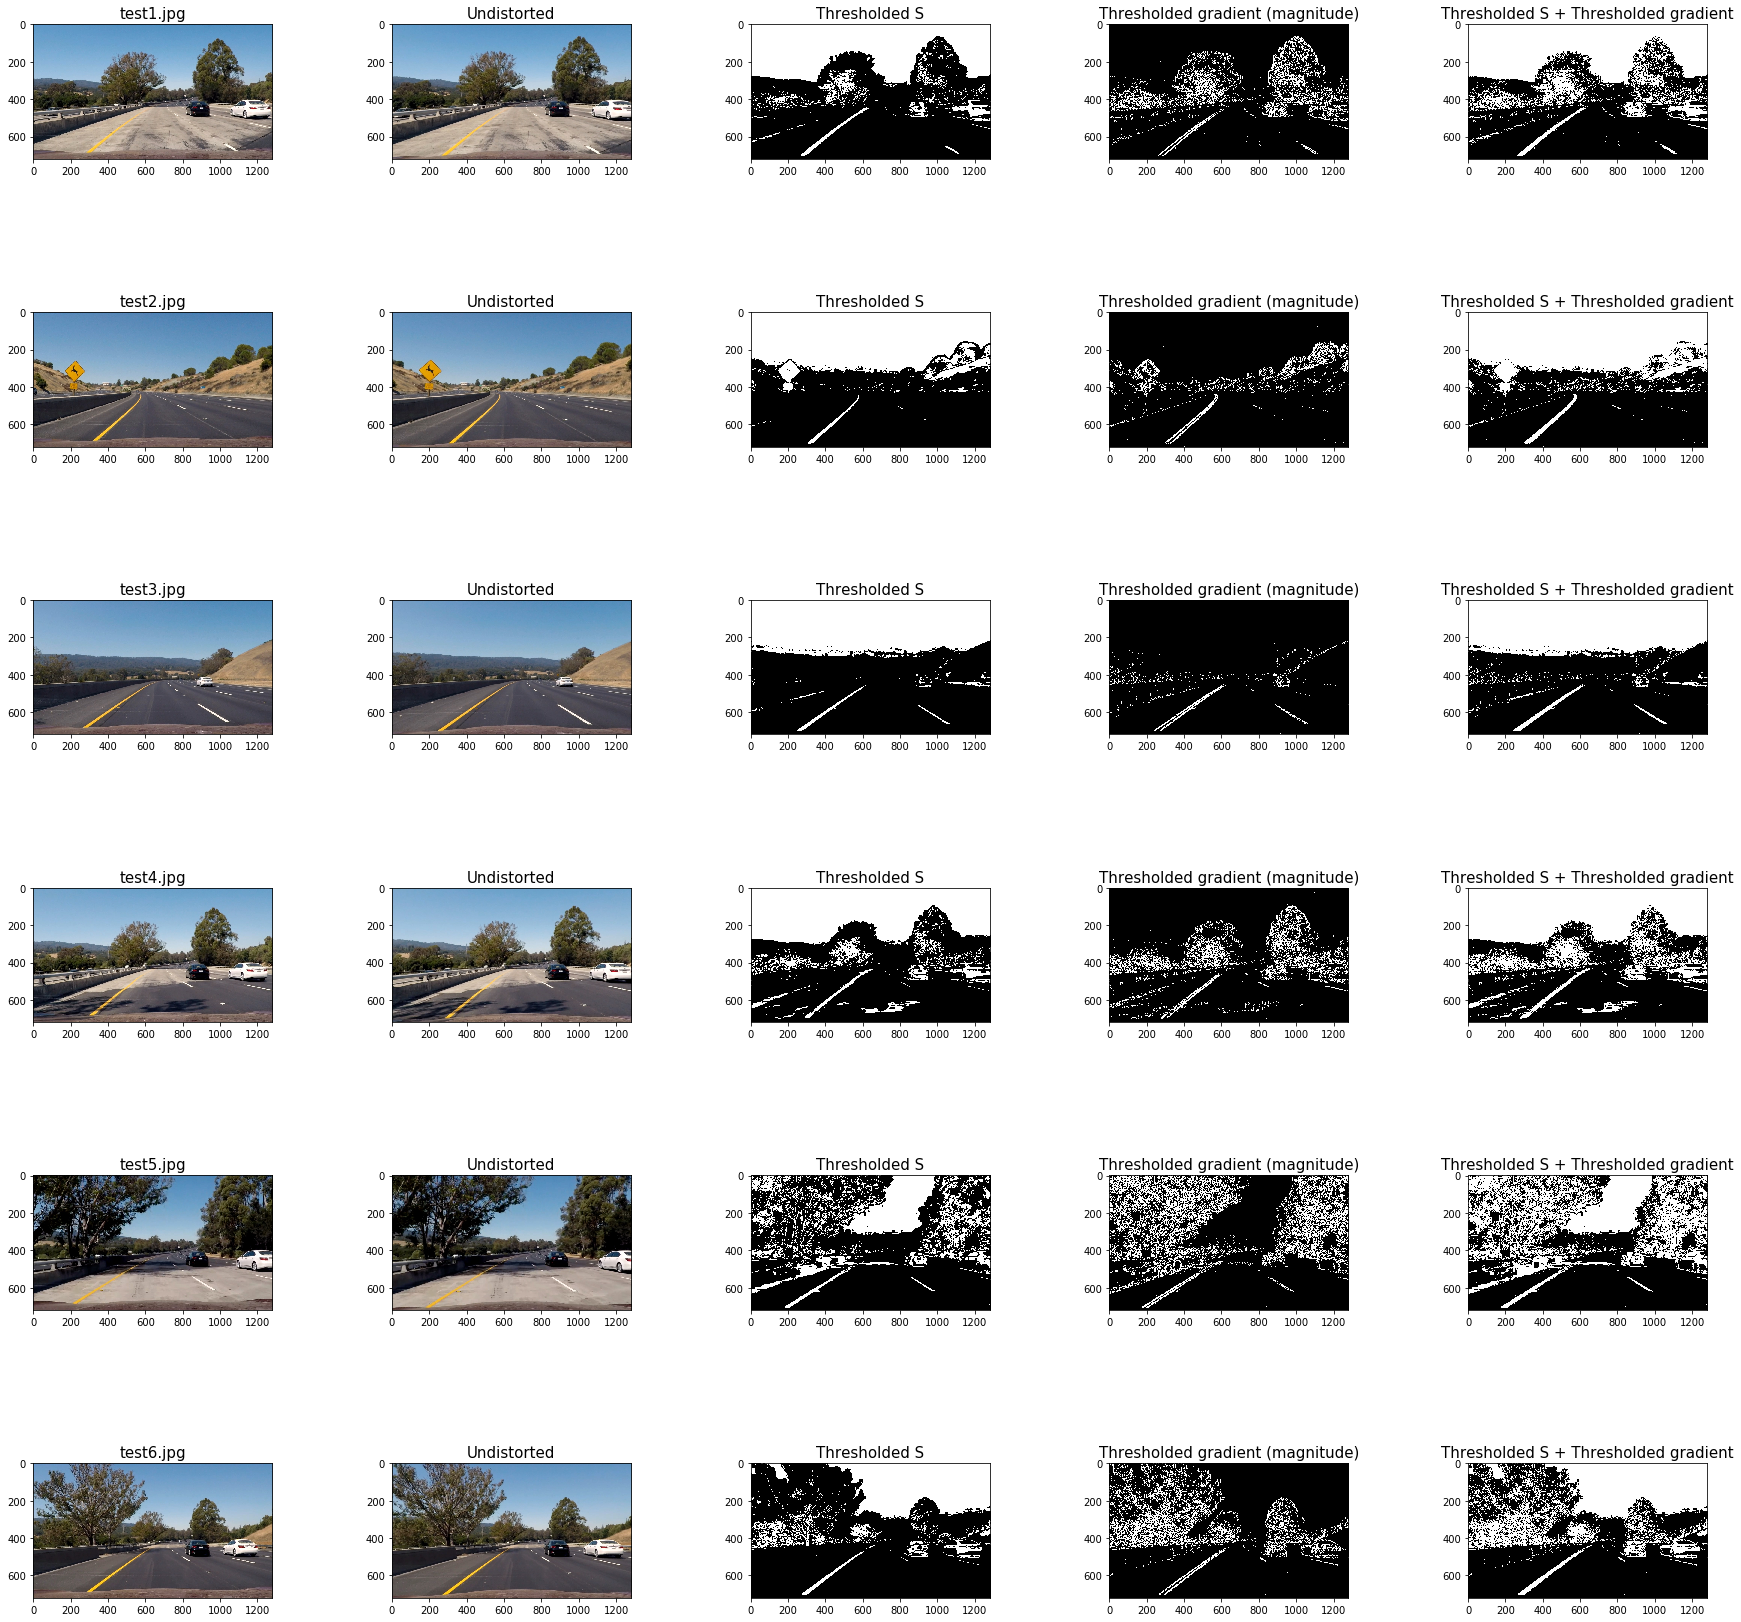

In [3]:
%matplotlib inline

types = 5
f, axes = plt.subplots(len(images), types, figsize=(30,30))
axes = axes.ravel()

binary_select_dict = {}
for i, image in enumerate(images):
    fname = os.path.basename(images_filename[i])
    axes[types*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[types*i].set_title(fname, fontsize=15)
    
    undistorted_image = undistort(image, mtx, dist)
    axes[types*i+1].imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
    axes[types*i+1].set_title('Undistorted', fontsize=15)
    
    hls = bgr_to_hls(undistorted_image)
    hls_binary = hls_channel_select(hls, thresh=(90, 255), channel=2)
    axes[types*i+2].imshow(hls_binary, cmap='gray')
    axes[types*i+2].set_title('Thresholded S', fontsize=15)
    
    mag_sobel_binary = mag_sobel_hls(hls, thresh=(10,100))
    axes[types*i+3].imshow(mag_sobel_binary, cmap='gray')
    axes[types*i+3].set_title('Thresholded gradient (magnitude)', fontsize=15)
    
    binary_select = cv2.bitwise_or(hls_binary, mag_sobel_binary)
    binary_select_dict[fname] = binary_select
    axes[types*i+4].imshow(binary_select, cmap='gray')
    axes[types*i+4].set_title('Thresholded S + Thresholded gradient', fontsize=15)
    
plt.subplots_adjust(wspace=0.5, hspace = 0.5)

In [4]:
def line_finding(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, ploty, left_fitx, right_fitx

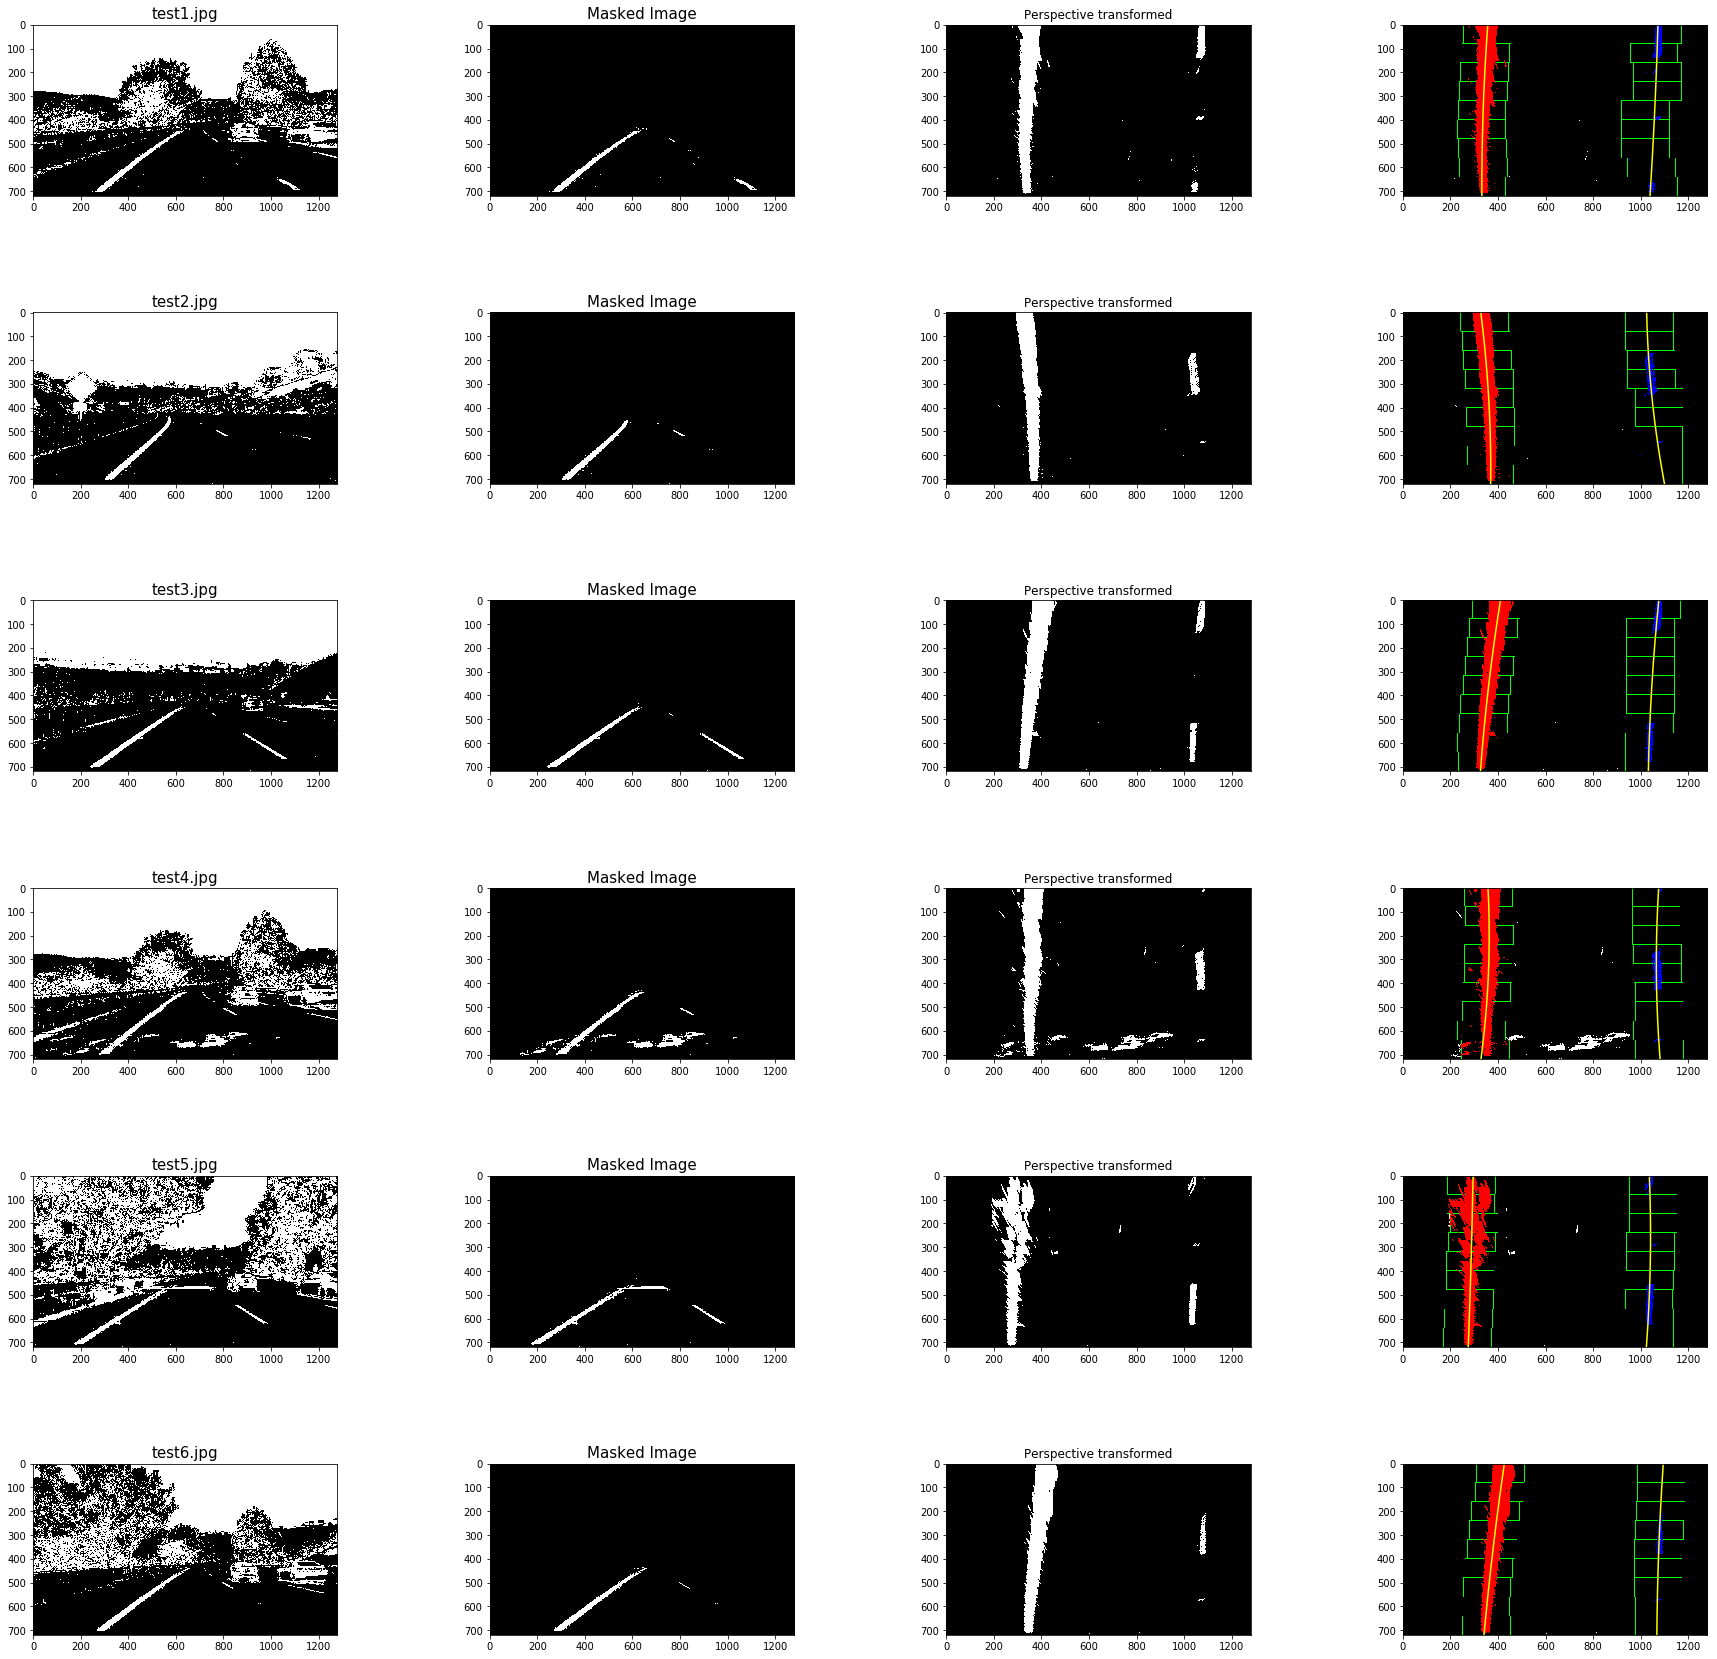

In [5]:
%matplotlib inline

types = 4
f, axes = plt.subplots(len(images), types, figsize=(30,30))
axes = axes.ravel()

i=0
for fname, binary_select in sorted(binary_select_dict.items()):
    axes[types*i].imshow(binary_select, cmap='gray')
    axes[types*i].set_title(fname, fontsize=15)
    
    vertices = calculate_vertices(binary_select)
    masked_edges = region_of_interest(binary_select, vertices)
    axes[types*i+1].imshow(masked_edges, cmap='gray')
    axes[types*i+1].set_title('Masked Image', fontsize=15)
    
    binary_warped = perspective_transform(masked_edges)
    axes[types*i+2].imshow(binary_warped, cmap='gray')
    axes[types*i+2].set_title('Perspective transformed')
    
    line, ploty, left_fitx, right_fitx = line_finding(binary_warped)
    axes[types*i+3].imshow(line)
    axes[types*i+3].plot(left_fitx, ploty, color='yellow')
    axes[types*i+3].plot(right_fitx, ploty, color='yellow')
    
    i+=1
plt.subplots_adjust(wspace=0.5, hspace = 0.5)